In [1]:
# Synthetic dataset for multi-class classification of support tickets
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

np.random.seed(42)

labels = ["billing", "login", "bug", "feature_request", "cancellation", "other"]

examples = [
    ("I was charged twice for my subscription this month.", "billing"),
    ("Payment failed but money was deducted.", "billing"),
    ("Can't reset my password, the email never arrives.", "login"),
    ("2FA code is not working and I'm locked out.", "login"),
    ("App crashes every time I open the settings page.", "bug"),
    ("Search results are empty even for common terms.", "bug"),
    ("Please add dark mode and font size controls.", "feature_request"),
    ("Would love an export to CSV option in reports.", "feature_request"),
    ("I want to cancel my plan effective immediately.", "cancellation"),
    ("How do I delete my account and cancel renewal?", "cancellation"),
    ("Where can I find your privacy policy?", "other"),
    ("Do you support Hindi language UI?", "other"),
]

# Expand to ~60 rows by adding slight variations
rows = []
for i in range(60):
    text, y = examples[np.random.randint(0, len(examples))]
    # tiny noise
    text2 = text + (" Please help." if np.random.rand() < 0.4 else "")
    rows.append((text2, y))

df = pd.DataFrame(rows, columns=["ticket_text", "true_label"])
df.head()

,ticket_text,true_label
0,Please add dark mode and font size controls.,feature_request
1,Where can I find your privacy policy?,other
2,App crashes every time I open the settings pag...,bug
3,"Can't reset my password, the email never arriv...",login
4,Where can I find your privacy policy?,other


In [2]:
# Create prompt template
PROMPT = """
You are a customer support triage assistant.
Classify the ticket into exactly one category from:
[billing, login, bug, feature_request, cancellation, other]

Return ONLY the label.
Ticket:
"""
print(PROMPT)


You are a customer support triage assistant.
Classify the ticket into exactly one category from:
[billing, login, bug, feature_request, cancellation, other]

Return ONLY the label.
Ticket:



In [3]:
# Mock LLM prediction function
def mock_llm_predict(text):
    t = text.lower()
    if any(k in t for k in ["charged", "payment", "refund", "billing", "deducted"]):
        return "billing"
    if any(k in t for k in ["password", "login", "locked", "2fa", "otp"]):
        return "login"
    if any(k in t for k in ["crash", "bug", "error", "broken", "not working"]):
        return "bug"
    if any(k in t for k in ["add", "feature", "would love", "please include", "dark mode", "export"]):
        return "feature_request"
    if any(k in t for k in ["cancel", "cancellation", "delete my account", "stop renewal"]):
        return "cancellation"
    return "other"

df["pred_label_v1"] = df["ticket_text"].apply(mock_llm_predict)
df.head()

,ticket_text,true_label,pred_label_v1
0,Please add dark mode and font size controls.,feature_request,feature_request
1,Where can I find your privacy policy?,other,other
2,App crashes every time I open the settings pag...,bug,bug
3,"Can't reset my password, the email never arriv...",login,login
4,Where can I find your privacy policy?,other,other


In [4]:
# Confusion matrix
print(classification_report(df["true_label"], df["pred_label_v1"], digits=3))

                 precision    recall  f1-score   support

        billing      1.000     1.000     1.000         9
            bug      1.000     0.333     0.500         3
   cancellation      1.000     1.000     1.000        10
feature_request      1.000     1.000     1.000        12
          login      1.000     1.000     1.000        12
          other      0.875     1.000     0.933        14

       accuracy                          0.967        60
      macro avg      0.979     0.889     0.906        60
   weighted avg      0.971     0.967     0.959        60



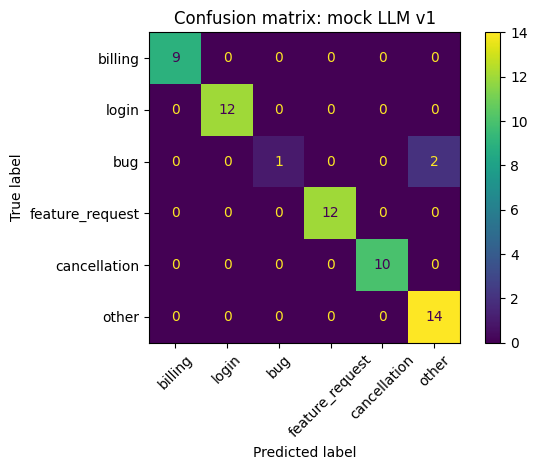

In [5]:
# Confusion matrix
cm = confusion_matrix(df["true_label"], df["pred_label_v1"], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion matrix: mock LLM v1")
plt.tight_layout()
plt.show()

In [6]:
# Show some error examples
errors = df[df["true_label"] != df["pred_label_v1"]].copy()
errors.head(20)

,ticket_text,true_label,pred_label_v1
8,Search results are empty even for common terms...,bug,other
28,Search results are empty even for common terms...,bug,other


In [7]:
# Most common error types
errors.groupby(["true_label", "pred_label_v1"]).size().sort_values(ascending=False).head(10)

true_label  pred_label_v1
bug         other            2
dtype: int64

In [8]:
# Improved mock LLM prediction function v2
def mock_llm_predict_v2(text):
    t = text.lower()
    # prioritize cancellation keywords
    if any(k in t for k in ["cancel", "cancellation", "delete my account", "close my account", "stop renewal"]):
        return "cancellation"
    if any(k in t for k in ["charged", "payment", "refund", "billing", "deducted"]):
        return "billing"
    if any(k in t for k in ["password", "login", "locked", "2fa", "otp"]):
        return "login"
    if any(k in t for k in ["crash", "bug", "error", "broken", "not working"]):
        return "bug"
    if any(k in t for k in ["dark mode", "export", "feature", "would love", "please add"]):
        return "feature_request"
    return "other"

df["pred_label_v2"] = df["ticket_text"].apply(mock_llm_predict_v2)

print("V1 report:\n", classification_report(df["true_label"], df["pred_label_v1"], digits=3))
print("V2 report:\n", classification_report(df["true_label"], df["pred_label_v2"], digits=3))

V1 report:
                  precision    recall  f1-score   support

        billing      1.000     1.000     1.000         9
            bug      1.000     0.333     0.500         3
   cancellation      1.000     1.000     1.000        10
feature_request      1.000     1.000     1.000        12
          login      1.000     1.000     1.000        12
          other      0.875     1.000     0.933        14

       accuracy                          0.967        60
      macro avg      0.979     0.889     0.906        60
   weighted avg      0.971     0.967     0.959        60

V2 report:
                  precision    recall  f1-score   support

        billing      1.000     1.000     1.000         9
            bug      1.000     0.333     0.500         3
   cancellation      1.000     1.000     1.000        10
feature_request      1.000     1.000     1.000        12
          login      1.000     1.000     1.000        12
          other      0.875     1.000     0.933        14

  